In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 

In [2]:
adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/human_lymph_cosmx_309.h5ad')
adata

AnnData object with n_obs × n_vars = 4354 × 6175
    obs: 'cell_type', 'cell_type_orig'
    uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [3]:
tonsil = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
tonsil_banksy = pd.read_csv('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/tonsil_banksy_celltypes.csv', index_col=0)
tonsil.obs['banksy_celltype'] = tonsil_banksy.loc[tonsil.obs_names, 'banksy_celltypes'].values
tonsil.obs['banksy_celltype'].value_counts() 

banksy_celltype
T_CD4                   1093
B_memory                 909
GC Light Zone            726
B_naive                  712
GC Dark Zone             560
GC Intermediate Zone     457
T_follicular_helper      334
plasma                   274
mDC/myeloid              240
FDC                      220
T_CD8                    198
pDC                       55
Name: count, dtype: int64

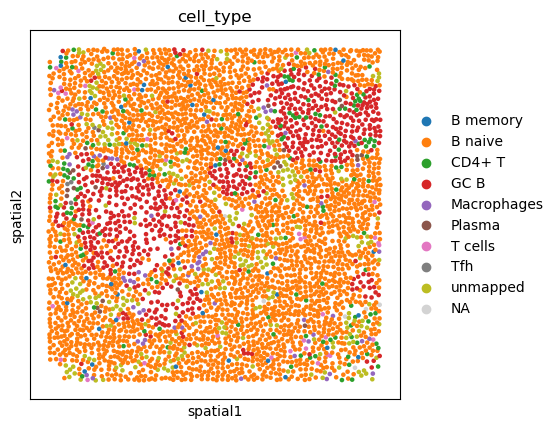

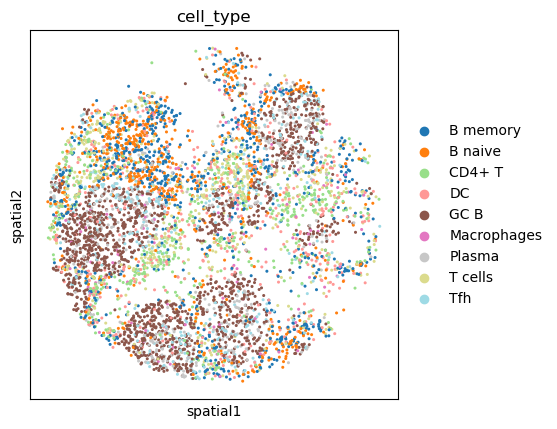

In [11]:
sc.pl.spatial(adata, color='cell_type', spot_size=0.007)
sc.pl.spatial(tonsil, color='cell_type', spot_size=20)

### Shared genes only

In [36]:
shared_genes = set(adata.var_names) & set(tonsil.var_names)
shared_genes = list(shared_genes)

adata = adata[:, shared_genes]
tonsil = tonsil[:, shared_genes]

adata, tonsil

(View of AnnData object with n_obs × n_vars = 4354 × 1377
     obs: 'cell_type', 'cell_type_orig', 'x', 'y'
     uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'normalized_count', 'raw_count'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 5778 × 1377
     obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2', 'banksy_celltype'
     uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap', 'banksy_celltype_colors'
     obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
     varm: 'PCs'
     layers: 'imputed_count', 'normalized_count'
     obsp: 'connectivities', 'distances')

### Run banksy

In [37]:
import sys
sys.path.append('/ix/djishnu/alw399/SpaceOracle/src/Banksy_py')
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
from banksy_utils.load_data import load_adata, display_adata

In [39]:
raw_x, raw_y = adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1]

In [40]:
from banksy.main import median_dist_to_nearest_neighbour

In [41]:
plot_graph_weights = True
k_geom = 15 # number of spatial neighbours
max_m = 1 # use both mean and AFT
nbr_weight_decay = "scaled_gaussian" # can also choose "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours
nbrs = median_dist_to_nearest_neighbour(adata, key = 'spatial')


Median distance to closest cell = 0.005899559305575437

---- Ran median_dist_to_nearest_neighbour in 0.02 s ----



In [42]:
adata.obs['x'] = raw_x
adata.obs['y'] = raw_y


Median distance to closest cell = 0.005899559305575437

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----

---- Ran generate_spatial_distance_graph in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.14 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 0.012518019012606855, mode = 0.014968575757335902

---- Ran plot_edge_histogram in 0.09 s ----


Edge weights (weights between cells): median = 0.05919447637823108, mode = 0.031286976361804796

---- Ran plot_edge_histogram in 0.05 s ----

---- Ran generate_spatial_distance_graph in 0.02 s ----

---- Ran theta_from_spatial_graph in 0.03 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.19 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 0.017350273773056084, mode = 0.021563752713048456

---- Ran plot_edge_histogram in 0.05 

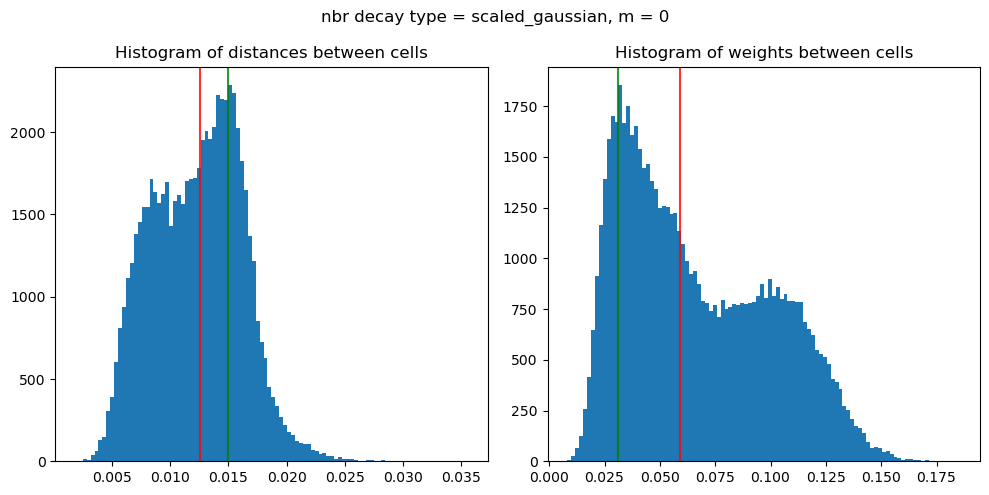

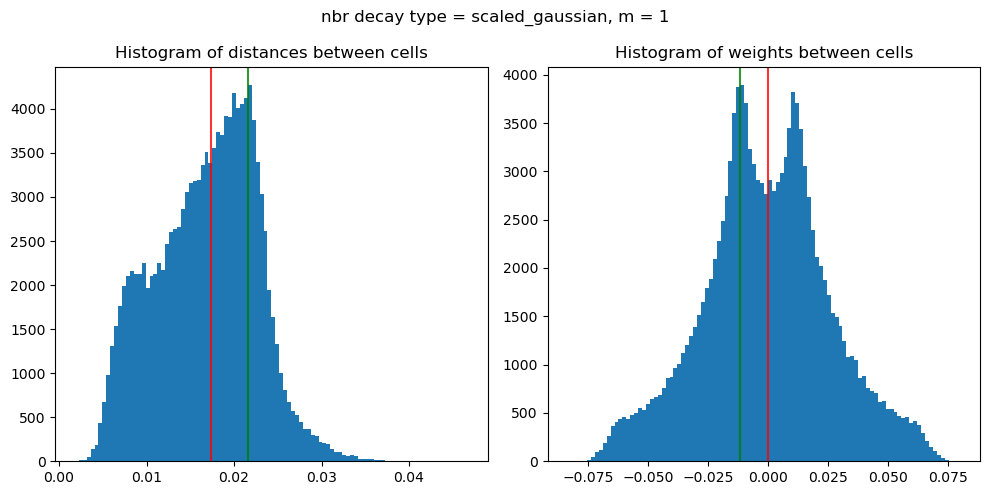

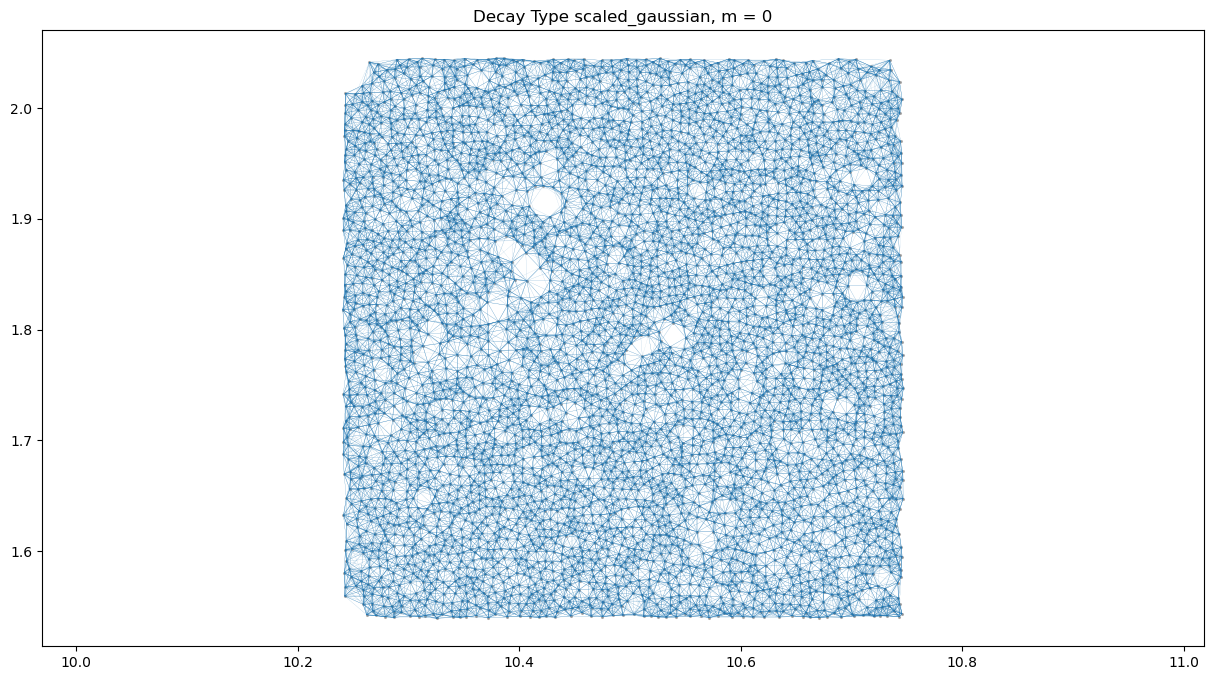

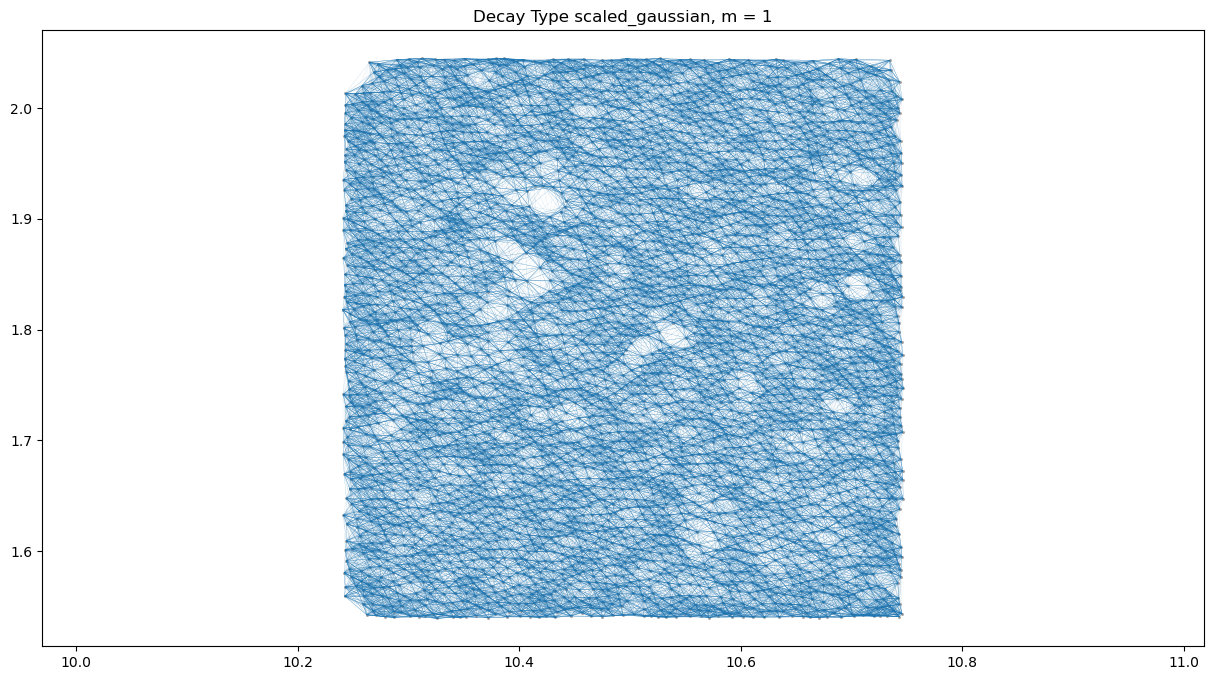

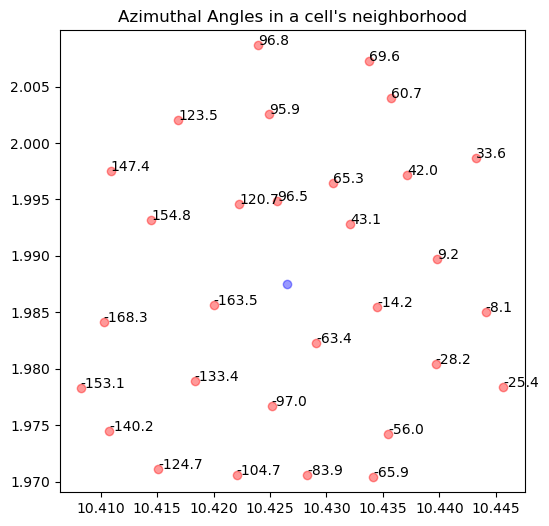

In [43]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata,
    ('x', 'y', 'spatial'),
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

In [44]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
# -----------------------------------------------------
resolutions = [0.6]  # clustering resolution for UMAP
pca_dims = [50]  # Dimensionality in which PCA reduces to
lambda_list = [0.2]  # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m)
banksy_matrix

Runtime May-02-2025-17-37

1377 genes to be analysed:
Gene List:
Index(['PLK3', 'HLA-G', 'SVIL', 'SASH1', 'CALD1', 'RGPD5', 'NAV3', 'NECTIN3',
       'LGR5', 'TFPI',
       ...
       'TICAM1', 'CTBP2', 'EPHA2', 'IL34', 'DEPTOR', 'LPIN2', 'PXN', 'PRDM16',
       'DSCAML1', 'TSPAN14'],
      dtype='object', length=1377)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <4354x4354 sparse matrix of type '<class 'numpy.float64'>'
	with 65310 stored elements in Compressed Sparse Row format>, 1: <4354x4354 sparse matrix of type '<class 'numpy.complex128'>'
	with 130620 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.05 | Std: 0.12
Size of Nbr | Shape: (4354, 1377)
Top 3 entries of Nbr Mat:

[[0.03168375 0.16548876 0.        ]
 [0.02421811 0.22731787 0.        ]
 [0.         0.22545179 0.        ]]

AGF matrix | Mean: 0.03 | Std: 0.03
Size of AGF mat (m = 1) | Shape: (4354, 1377)
Top entries of AGF:
[[0.00263

AnnData object with n_obs × n_vars = 4354 × 4131
    obs: 'cell_type', 'cell_type_orig', 'x', 'y'
    var: 'is_nbr', 'k'

In [47]:
banksy_matrix.to_df().to_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/human_lymph_cosmx_embedding.parquet')


In [48]:
raw_x, raw_y = tonsil.obsm['spatial'][:, 0], tonsil.obsm['spatial'][:, 1]

In [49]:
plot_graph_weights = True
k_geom = 15 # number of spatial neighbours
max_m = 1 # use both mean and AFT
nbr_weight_decay = "scaled_gaussian" # can also choose "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours
nbrs = median_dist_to_nearest_neighbour(tonsil, key = 'spatial')


Median distance to closest cell = 9.999999999999794

---- Ran median_dist_to_nearest_neighbour in 0.02 s ----



In [50]:
tonsil.obs['x'] = raw_x
tonsil.obs['y'] = raw_y


Median distance to closest cell = 9.999999999999794

---- Ran median_dist_to_nearest_neighbour in 0.02 s ----

---- Ran generate_spatial_distance_graph in 0.15 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.31 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 33.81533106908918, mode = 34.58927767314821

---- Ran plot_edge_histogram in 0.08 s ----


Edge weights (weights between cells): median = 0.057726872039865165, mode = 0.041943398344353726

---- Ran plot_edge_histogram in 0.06 s ----

---- Ran generate_spatial_distance_graph in 0.05 s ----

---- Ran theta_from_spatial_graph in 0.05 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.27 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 48.15919089430059, mode = 52.78642568954706

---- Ran plot_edge_histogram in 0.08 s ----


Edge 

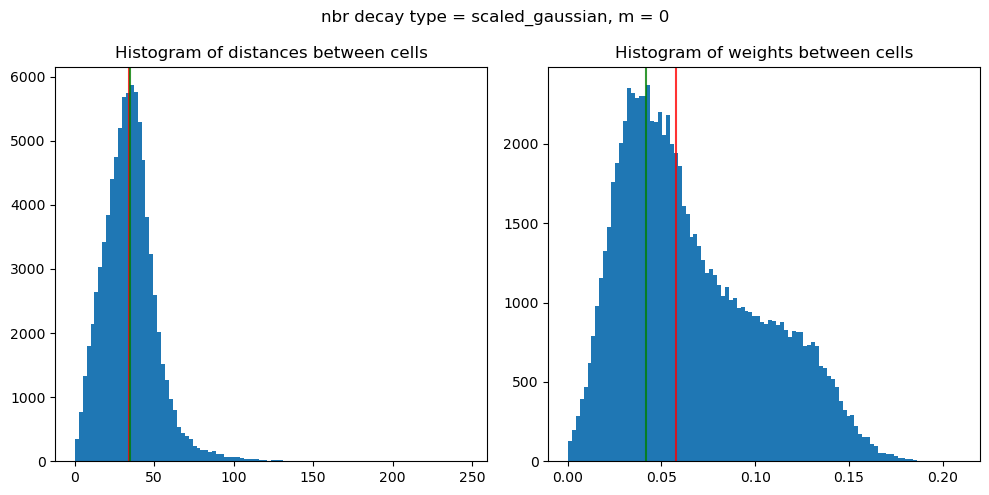

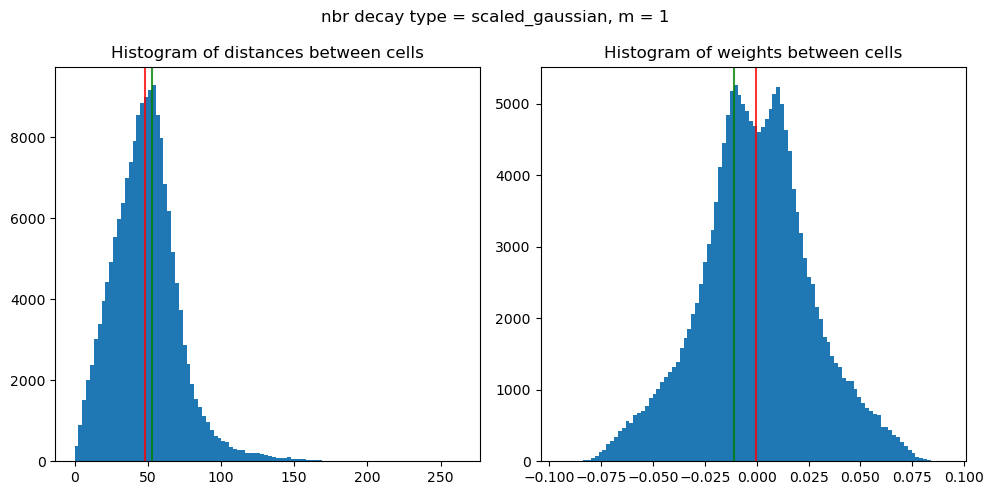

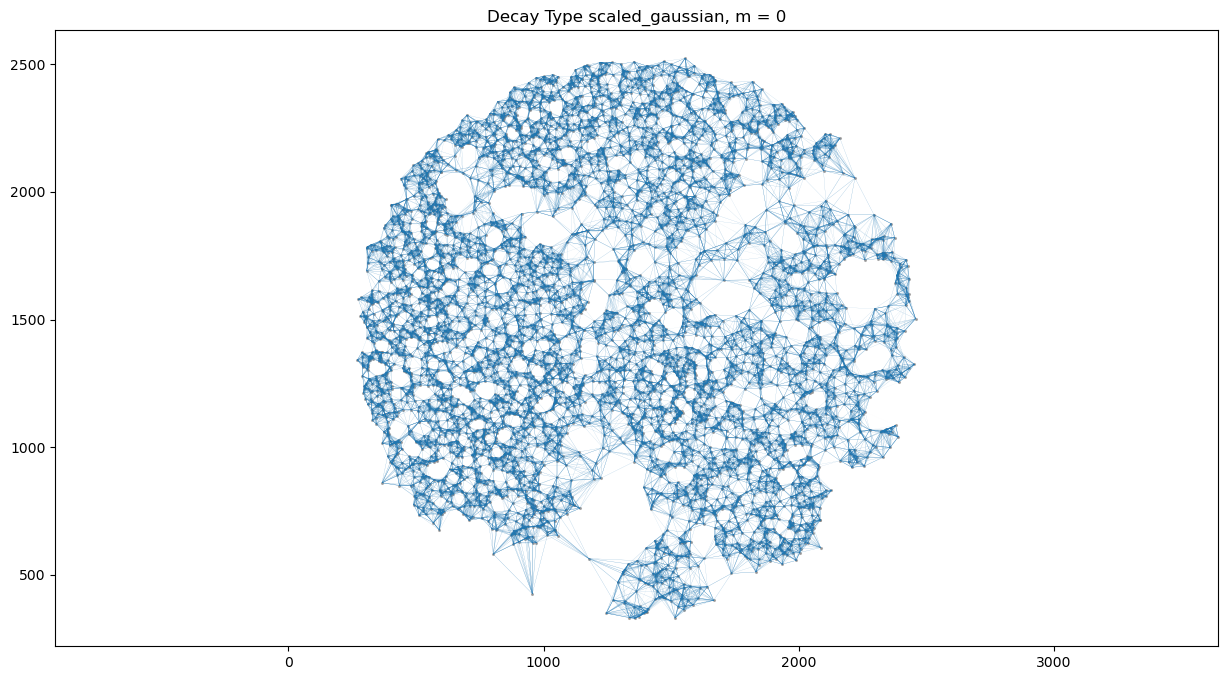

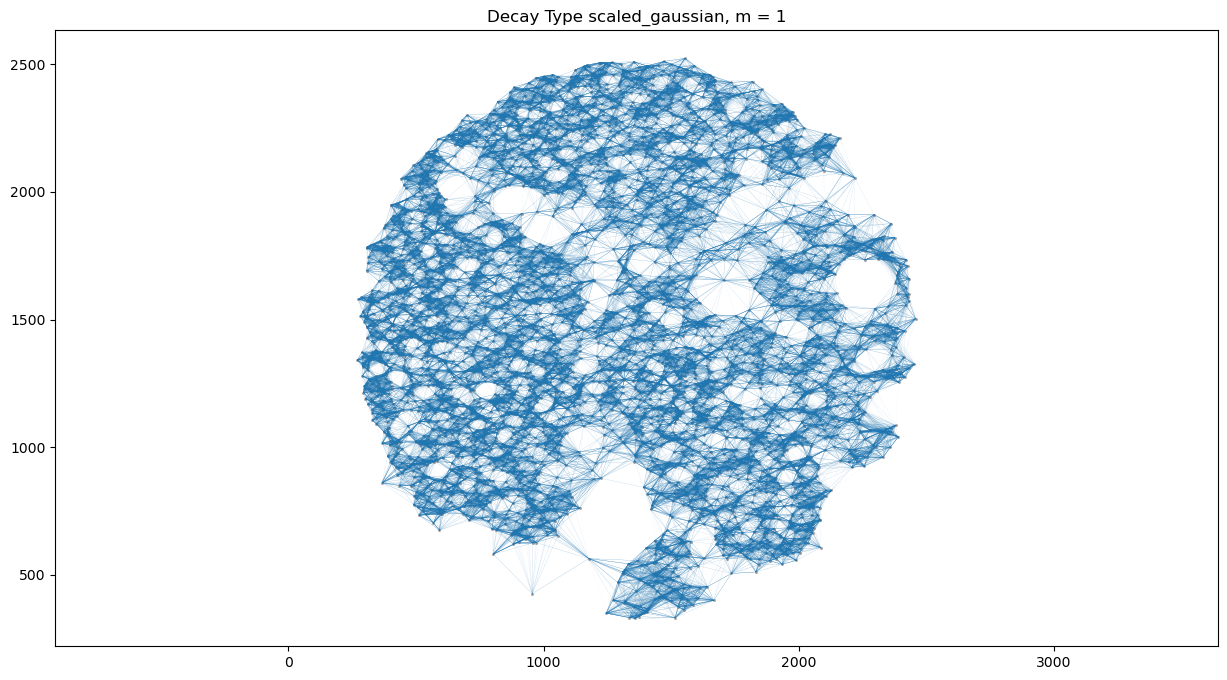

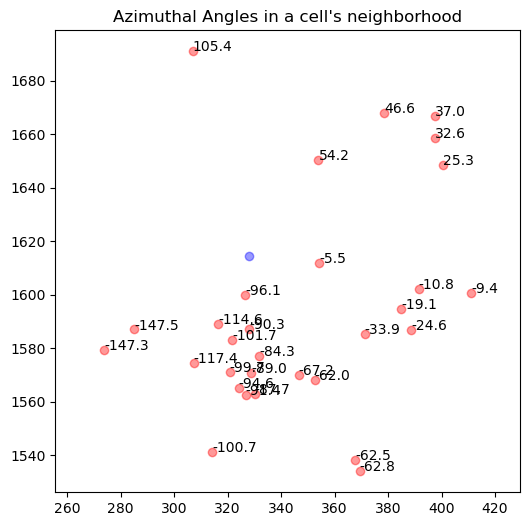

In [51]:
banksy_dict = initialize_banksy(
    tonsil,
    ('x', 'y', 'spatial'),
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

In [52]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
# -----------------------------------------------------
resolutions = [0.6]  # clustering resolution for UMAP
pca_dims = [50]  # Dimensionality in which PCA reduces to
lambda_list = [0.2]  # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(tonsil,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m)
banksy_matrix

Runtime May-02-2025-17-40

1377 genes to be analysed:
Gene List:
Index(['PLK3', 'HLA-G', 'SVIL', 'SASH1', 'CALD1', 'RGPD5', 'NAV3', 'NECTIN3',
       'LGR5', 'TFPI',
       ...
       'TICAM1', 'CTBP2', 'EPHA2', 'IL34', 'DEPTOR', 'LPIN2', 'PXN', 'PRDM16',
       'DSCAML1', 'TSPAN14'],
      dtype='object', name='Unnamed: 0', length=1377)

Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <5778x5778 sparse matrix of type '<class 'numpy.float64'>'
	with 86670 stored elements in Compressed Sparse Row format>, 1: <5778x5778 sparse matrix of type '<class 'numpy.complex128'>'
	with 173340 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.16 | Std: 0.32
Size of Nbr | Shape: (5778, 1377)
Top 3 entries of Nbr Mat:

[[0.10095167 0.         0.23267491]
 [0.         0.         0.        ]
 [0.14304101 0.         0.        ]]

AGF matrix | Mean: 0.06 | Std: 0.08
Size of AGF mat (m = 1) | Shape: (5778, 1377)
Top entries of AGF:
[[0.03008393 0.         0.17142924]
 [0

AnnData object with n_obs × n_vars = 5778 × 4131
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2', 'banksy_celltype', 'x', 'y'
    var: 'is_nbr', 'k'

In [55]:
banksy_matrix.to_df().to_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/snrna_human_tonsil_embedding.parquet')


### Mapping

In [60]:
ref_embed = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/snrna_human_tonsil_embedding.parquet')
test_embed = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/human_lymph_cosmx_embedding.parquet')

In [59]:
test_adata = adata.copy()
ref_adata = tonsil.copy()

test_adata, ref_adata

(AnnData object with n_obs × n_vars = 4354 × 1377
     obs: 'cell_type', 'cell_type_orig', 'x', 'y'
     uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'normalized_count', 'raw_count'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 5778 × 1377
     obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2', 'banksy_celltype', 'x', 'y'
     uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap', 'banksy_celltype_colors'
     obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
     varm: 'PCs'
     layers: 'imputed_count', 'normalized_count'
     obsp: 'connectivities', 'distances')

In [61]:
test_embed = test_embed.reindex(test_adata.obs.index, axis=0)
test_embed = test_embed.reindex(ref_embed.columns, axis=1)

ref_embed = ref_embed.reindex(ref_adata.obs.index, axis=0)

In [62]:
test_adata = sc.AnnData(
    X = test_embed.values,
    obs = test_adata.obs,
    var = pd.DataFrame(index=test_embed.columns),
    obsm = test_adata.obsm
)

ref_adata = sc.AnnData(
    X = ref_embed.values,
    obs = ref_adata.obs,
    var = pd.DataFrame(index=ref_embed.columns),
    obsm = ref_adata.obsm
)

In [63]:
test_adata.X.max(), ref_adata.X.max()

(18.085686232630263, 50.416724574612395)

In [64]:
test_adata.X.min(), ref_adata.X.min()

(-3.445339550635694, -2.9060767831586)

### Batch correct

In [65]:
adata2 = test_adata 
adata1 = ref_adata

adata1, adata2

(AnnData object with n_obs × n_vars = 5778 × 4131
     obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2', 'banksy_celltype', 'x', 'y'
     obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled',
 AnnData object with n_obs × n_vars = 4354 × 4131
     obs: 'cell_type', 'cell_type_orig', 'x', 'y'
     obsm: 'X_pca', 'X_umap', 'spatial')

2025-05-02 17:44:09,590 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-02 17:44:15,823 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-02 17:44:15,864 - harmonypy - INFO - Iteration 1 of 10
2025-05-02 17:44:17,402 - harmonypy - INFO - Iteration 2 of 10
2025-05-02 17:44:18,945 - harmonypy - INFO - Iteration 3 of 10
2025-05-02 17:44:21,487 - harmonypy - INFO - Iteration 4 of 10
2025-05-02 17:44:24,676 - harmonypy - INFO - Iteration 5 of 10
2025-05-02 17:44:26,302 - harmonypy - INFO - Iteration 6 of 10
2025-05-02 17:44:30,131 - harmonypy - INFO - Converged after 6 iterations


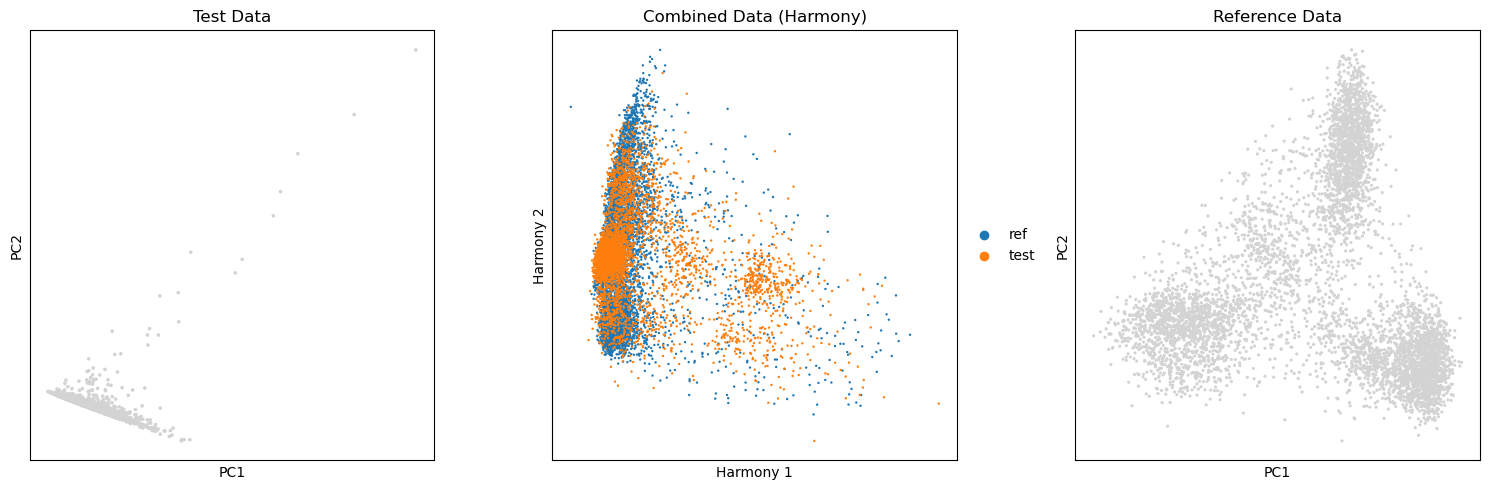

In [66]:
# Concatenate the adatas
adata_concat = adata1.concatenate(adata2)

# Add batch info
adata_concat.obs['batch'] = ['ref' if i < len(adata1) else 'test' for i in range(len(adata_concat))]

# Run PCA
sc.tl.pca(adata_concat)

# Run Harmony
import harmonypy as hp
ho = hp.run_harmony(adata_concat.obsm['X_pca'], adata_concat.obs, ['batch'])
adata_concat.obsm['X_harmony'] = ho.Z_corr.T

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot test data
sc.pl.pca(test_adata, show=False, ax=ax1, title='Test Data')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Plot combined data colored by batch
sc.pl.embedding(adata_concat, 'X_harmony', color='batch', show=False, ax=ax2, title='Combined Data (Harmony)')
ax2.set_xlabel('Harmony 1') 
ax2.set_ylabel('Harmony 2')

# Plot reference data
sc.pl.pca(ref_adata, show=False, ax=ax3, title='Reference Data')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')

plt.tight_layout()
plt.show()


In [67]:
pd.DataFrame(
    adata_concat.obsm['X_harmony'], 
    index=adata_concat.obs.index,
    columns=[f'X_harmony_{i}' for i in range(50)]
).to_csv('banksy_subsampled_harmony.csv')

In [68]:
test_adata = sc.AnnData(
    X = adata_concat[test_adata.obs.index + '-1'].obsm['X_harmony'],
    obs = test_adata.obs,
    var = [f'X_harmony_{i}' for i in range(50)],
    obsm = test_adata.obsm
)

ref_adata = sc.AnnData(
    X = adata_concat[ref_adata.obs.index + '-0'].obsm['X_harmony'],
    obs = ref_adata.obs,
    var = [f'X_harmony_{i}' for i in range(50)],
    obsm = ref_adata.obsm
)

In [109]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import pandas as pd

# Get the X matrices from both AnnData objects
test_X = test_adata.X
ref_X = ref_adata.X

# Get cell types
test_cell_types = test_adata.obs['cell_type'].astype(str).values  # Assuming the column is called 'cell_type'
ref_cell_types = ref_adata.obs['cell_type'].astype(str).values    # Adjust if your column name is different

# Create a dataframe to store the results
result_df = pd.DataFrame(index=test_adata.obs.index, columns=['reference_cell'])

# Calculate distances and find most similar cells for each cell type separately
for cell_type in np.unique(test_cell_types):
    # Get indices of cells with this cell type
    test_indices = np.where(test_cell_types == cell_type)[0]
    ref_indices = np.where(ref_cell_types == cell_type)[0]
    
    # Skip if no reference cells of this type
    if len(ref_indices) == 0:
        print(f"Warning: No reference cells found for cell type '{cell_type}'. Skipping {len(test_indices)} test cells.")
        continue
    
    # Extract the relevant subset of cells
    test_subset_X = test_X[test_indices]
    ref_subset_X = ref_X[ref_indices]
    
    # Calculate distances between cells of this type only
    distances_subset = euclidean_distances(test_subset_X, ref_subset_X)
    
    # Find most similar reference cell for each test cell
    most_similar_subset_indices = np.argmin(distances_subset, axis=1)
    
    # Map back to the original reference indices
    most_similar_ref_indices = ref_indices[most_similar_subset_indices]
    
    # Get the cell IDs
    test_cell_ids = test_adata.obs.index.values[test_indices]
    most_similar_cells = ref_adata.obs.index.values[most_similar_ref_indices]
    
    # Update the result dataframe
    for i, test_id in enumerate(test_cell_ids):
        result_df.loc[test_id, 'reference_cell'] = most_similar_cells[i]

# Add cell type columns for verification
result_df['test_cell_type'] = pd.Series(test_cell_types, index=test_adata.obs.index)
result_df['ref_cell_type'] = result_df['reference_cell'].map(
    pd.Series(ref_cell_types, index=ref_adata.obs.index)
)

# Verify that cell types match
matching = (result_df['test_cell_type'] == result_df['ref_cell_type']).mean()
print(f"Cell type matching rate: {matching:.2%}")

# Save to CSV
result_df.to_csv('mapping_ct.csv')

print(f"Total test cells: {len(test_adata.obs.index)}")
print(f"Test cells mapped: {result_df['reference_cell'].notna().sum()}")
print(f"Test cells not mapped: {result_df['reference_cell'].isna().sum()}")

Cell type matching rate: 92.63%
Total test cells: 4354
Test cells mapped: 4033
Test cells not mapped: 321


In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances

# test_X = test_adata.X
# ref_X = ref_adata.X

# # Calculate pairwise distances between test and reference cells
# # This returns a matrix of shape (n_test_cells, n_ref_cells)
# distances = euclidean_distances(test_X, ref_X)

# # For each test cell, find the index of the reference cell with minimum distance
# most_similar_indices = np.argmin(distances, axis=1)

# # Get the actual cell IDs from the reference AnnData object
# ref_cell_ids = ref_adata.obs.index.values
# most_similar_cells = ref_cell_ids[most_similar_indices]

# # Create a dataframe with test cell IDs as index and most similar reference cell IDs as values
# result_df = pd.DataFrame(
#     {'reference_cell': most_similar_cells}, 
#     index=test_adata.obs.index
# )

# result_df.to_csv('mapping.csv')

In [77]:
result_df['test_cell_type'] = result_df.index.map(test_adata.obs['cell_type'])


In [79]:
result_df['ref_cell_type'] = result_df['reference_cell'].map(ref_adata.obs['cell_type'])


In [80]:
result_df.head(3)

reference_cell test_cell_type ref_cell_type
c_1_309_10    CAAGGGATCTCATGGA-1        B naive       B naive
c_1_309_100   TTGAACGGTGCCTGCA-1        B naive      B memory
c_1_309_1000  ACGGTTAAGGTCCGAA-1        B naive      B memory

In [82]:
result_df['test_cell_type'].value_counts()

test_cell_type
B naive        2916
GC B            746
unmapped        315
CD4+ T          184
Macrophages      72
B memory         45
T cells          39
Plasma           26
Tfh               5
Name: count, dtype: int64

In [83]:
result_df['ref_cell_type'].value_counts()

ref_cell_type
B memory       1179
B naive        1084
DC              626
GC B            514
Tfh             226
CD4+ T          197
Macrophages     191
T cells         180
Plasma          157
Name: count, dtype: int64

In [94]:
all_categories = result_df['ref_cell_type'].cat.categories.union(result_df['test_cell_type'].cat.categories)

result_df['ref_cell_type'] = result_df['ref_cell_type'].cat.set_categories(all_categories)
result_df['test_cell_type'] = result_df['test_cell_type'].cat.set_categories(all_categories)

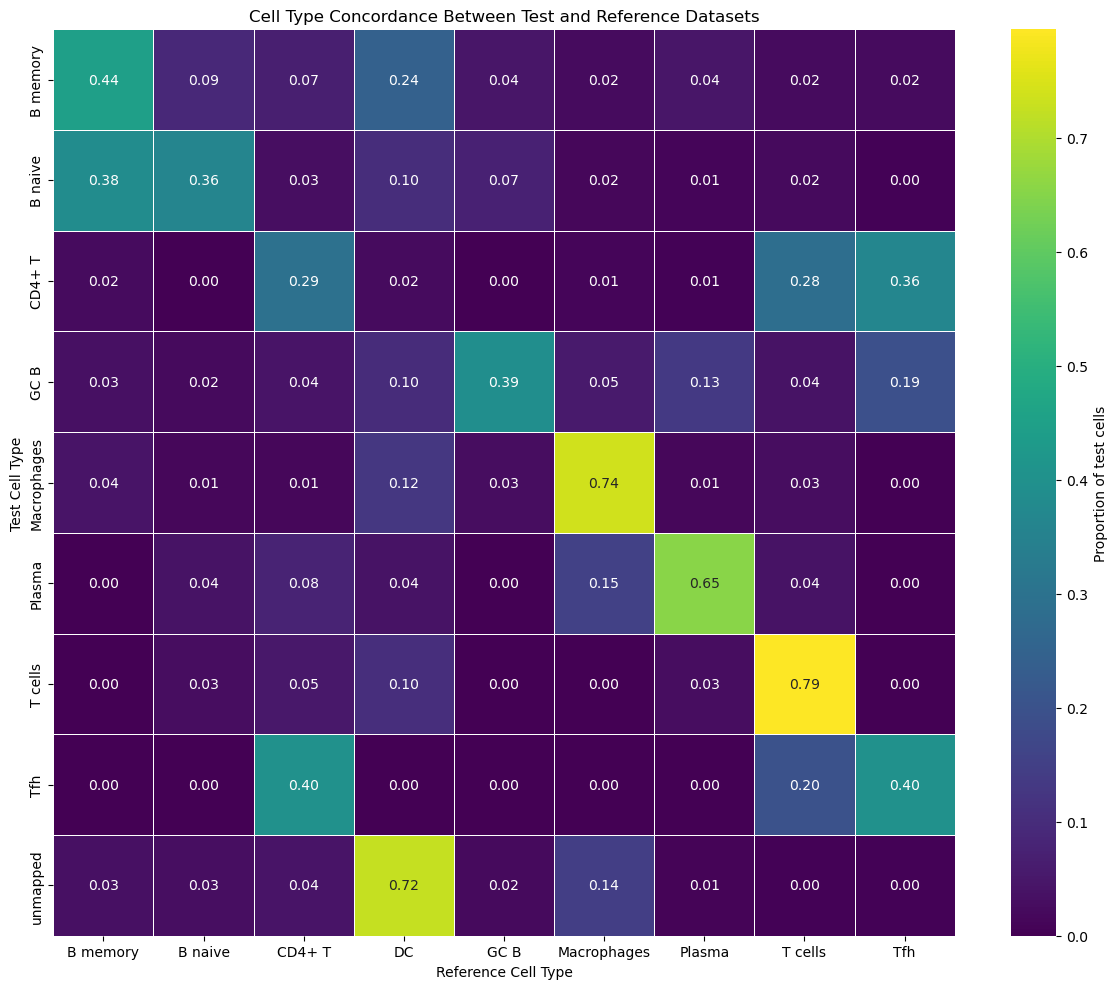

Overall concordance rate: 34.89%

Match distribution:
Matching cell types: 1519 cells
Non-matching cell types: 2835 cells

Concordance rate by test cell type:
test_cell_type
T cells       79.49%
Macrophages   73.61%
Plasma        65.38%
B memory      44.44%
Tfh           40.00%
GC B          38.87%
B naive       36.08%
CD4+ T        29.35%
unmapped       0.00%
DC               NaN


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a cross-tabulation of the cell types
confusion = pd.crosstab(
    result_df['test_cell_type'], 
    result_df['ref_cell_type'],
    normalize='index'  # Normalize by row (test cell types)
)

# Set up the figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(
    confusion, 
    annot=True,              # Show values in cells
    cmap='viridis',          # Color scheme
    fmt='.2f',               # Format for cell values (2 decimal places)
    linewidths=0.5,          # Width of cell borders
    cbar_kws={'label': 'Proportion of test cells'}  # Colorbar label
)

# Add labels and title
plt.xlabel('Reference Cell Type')
plt.ylabel('Test Cell Type')
plt.title('Cell Type Concordance Between Test and Reference Datasets')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

# You can also calculate overall concordance rate
concordance_rate = (result_df['test_cell_type'] == result_df['ref_cell_type']).mean()
print(f"Overall concordance rate: {concordance_rate:.2%}")

# Show distribution of correct/incorrect matches
match_status = (result_df['test_cell_type'] == result_df['ref_cell_type'])
match_counts = match_status.value_counts()
print("\nMatch distribution:")
print(f"Matching cell types: {match_counts.get(True, 0)} cells")
print(f"Non-matching cell types: {match_counts.get(False, 0)} cells")

# Concordance by cell type
by_cell_type = result_df.groupby('test_cell_type').apply(
    lambda x: (x['test_cell_type'] == x['ref_cell_type']).mean()
).sort_values(ascending=False)

print("\nConcordance rate by test cell type:")
print(by_cell_type.to_string(float_format="{:.2%}".format))